<a href="https://colab.research.google.com/github/salmakhale/DL-computer-vision/blob/main/DashCam_Crash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nexar_collision_prediction_path = kagglehub.competition_download('nexar-collision-prediction')

print('Data source import complete.')


In [ ]:
import gc
import tensorflow as tf

# Clear any previous TensorFlow session to free up memory
tf.keras.backend.clear_session()
gc.collect()  # Free up memory

print("Memory Cleared!")

Memory Cleared!


In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os

data_path = "/kaggle/input/nexar-collision-prediction/"
print(os.listdir(data_path))

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']


## Explore the Dataset


In [ ]:
import pandas as pd

# Load train.csv
train_df = pd.read_csv(f"{data_path}/train.csv")

print(train_df.head())

     id  time_of_event  time_of_alert  target
0  1924            NaN            NaN       0
1   822           19.5         18.633       1
2  1429            NaN            NaN       0
3   208           19.8         19.233       1
4  1904            NaN            NaN       0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1500 non-null   int64  
 1   time_of_event  750 non-null    float64
 2   time_of_alert  750 non-null    float64
 3   target         1500 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 47.0 KB


In [ ]:
#Explore data img
import os

# Count images in train folder
train_images = os.listdir(f"{data_path}/train")
test_images = os.listdir(f"{data_path}/test")

print(f"Number of training images: {len(train_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 1500
Number of test images: 1344


In [ ]:
# Fill missing values with the mean of each column
train_df['time_of_event'].fillna(train_df['time_of_event'].mean(), inplace=True)
train_df['time_of_alert'].fillna(train_df['time_of_alert'].mean(), inplace=True)

# Check if there are still missing values
print(train_df.isnull().sum())

id               0
time_of_event    0
time_of_alert    0
target           0
dtype: int64


In [ ]:
# Check the file extensions of images
image_extensions = [os.path.splitext(img)[1] for img in train_images]
print(set(image_extensions))  # Display unique file extensions

{'.mp4'}


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Image size
img_size = (224, 224)

# Load images
images = []
for img_name in train_images[:10]:  # Load the first 10 images
    img_path = os.path.join(data_path, 'train', img_name)
    try:
        img = image.load_img(img_path, target_size=img_size)
        img_array = image.img_to_array(img) / 255.0
        images.append(img_array)
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")

# Convert list to numpy array
images = np.array(images)
print(images.shape)


Error loading image 02059.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 01306.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 00238.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 00152.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 01734.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 00980.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 00729.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 01108.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 00443.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
Error loading image 01741.mp4: cannot identify image file <_io.BytesIO object at 0x7cd95c1caac0>
(0,)


In [ ]:
!pip install opencv-python

In [ ]:
import cv2
import os

# Function to extract frames from a video file
def extract_frames(video_path, max_frames=10):
    cap = cv2.VideoCapture(video_path)
    frames = []

    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # If the video has more than max_frames, we pick frames evenly spaced
    step = total_frames // max_frames

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()

        if ret:
            # Resize and normalize
            frame = cv2.resize(frame, (224, 224))  # Resize to 224x224
            frame = frame / 255.0  # Normalize pixel values to [0, 1]
            frames.append(frame)

    cap.release()
    return frames

# Example: Extract frames from the first video
video_path = os.path.join(data_path, 'train', '02059.mp4')
frames = extract_frames(video_path)
print(f"Extracted {len(frames)} frames from {video_path}")

Extracted 11 frames from /kaggle/input/nexar-collision-prediction/train/02059.mp4


In [ ]:
#Process All Video Files
all_frames = []
video_names = [video for video in train_images if video.endswith('.mp4')]

for video_name in video_names[:10]:
    video_path = os.path.join(data_path, 'train', video_name)
    frames = extract_frames(video_path)
    all_frames.extend(frames)

# Convert list of frames to numpy array
all_frames = np.array(all_frames)
print(f"Extracted {all_frames.shape[0]} frames in total.")

Extracted 107 frames in total.


## Data Analysis (EDA)

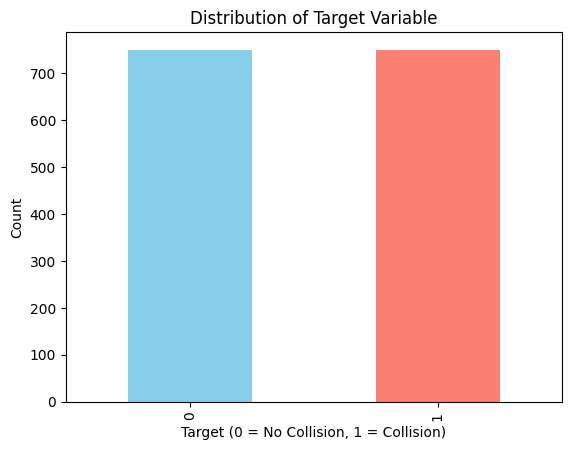

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the target variable
train_df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Distribution of Target Variable")
plt.xlabel("Target (0 = No Collision, 1 = Collision)")
plt.ylabel("Count")
plt.show()


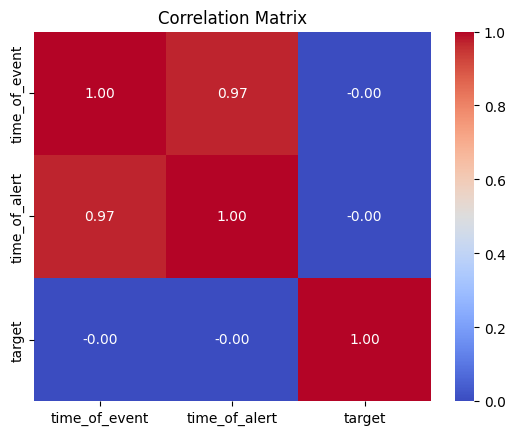

In [ ]:
# Correlation matrix
import seaborn as sns
correlation_matrix = train_df[['time_of_event', 'time_of_alert', 'target']].corr()

# Plotting the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
image_files = [f for f in os.listdir(os.path.join(data_path, 'train')) if f.endswith(('.jpg', '.png'))]
video_files = [f for f in os.listdir(os.path.join(data_path, 'train')) if f.endswith('.mp4')]

print(f"Number of image files: {len(image_files)}")
print(f"Number of video files: {len(video_files)}")

Number of image files: 0
Number of video files: 1500


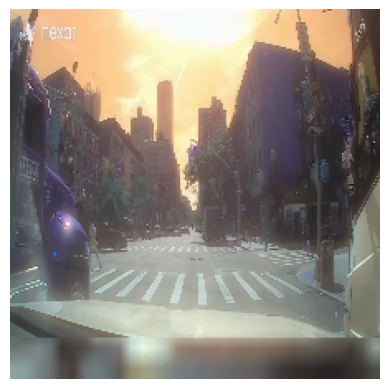

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Function to extract a frame from a video file
def extract_frame(video_path, frame_idx=0):
    cap = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Make sure the frame index is within range
    if frame_idx < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if ret:
            # Resize and normalize the frame
            frame_resized = cv2.resize(frame, (224, 224))
            frame_resized = frame_resized / 255.0
            return frame_resized
        else:
            print(f"Error: Couldn't read frame {frame_idx} from {video_path}")
            return None
    else:
        print(f"Error: Frame {frame_idx} exceeds total frames {total_frames} in {video_path}")
        cap.release()
        return None

# Extract and display frames from the first video
video_path = os.path.join(data_path, 'train', video_files[8])
frame = extract_frame(video_path, frame_idx=10)

if frame is not None:
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
else:
    print("Could not extract valid frame.")


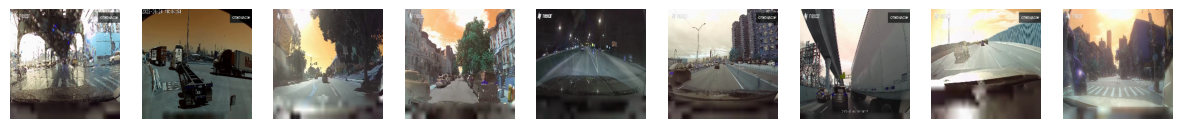

In [ ]:
# Display frames from the first videos
num_videos_to_display = min(9, len(video_files))
fig, axes = plt.subplots(1, num_videos_to_display, figsize=(15, 10))

for i, ax in enumerate(axes):
    video_path = os.path.join(data_path, 'train', video_files[i])
    frame = extract_frame(video_path, frame_idx=10)

    if frame is not None:
        ax.imshow(frame)
        ax.axis('off')
    else:
        ax.set_title(f"Error in video {i}")
        ax.axis('off')

plt.show()


## Visualizing Sample Extracted Frames

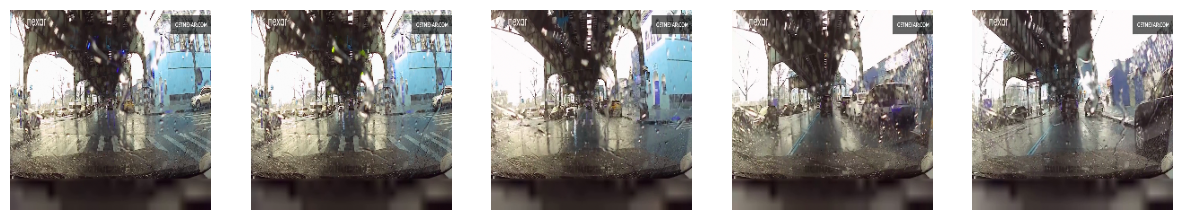

In [ ]:
import matplotlib.pyplot as plt

# Display the first 5 extracted frames
fig, axes = plt.subplots(1, 5, figsize=(15, 10))
for i, ax in enumerate(axes):
    ax.imshow(all_frames[i])
    ax.axis('off')
plt.show()

## Preprocess the Data

In [ ]:
import pandas as pd

# Load the train.csv file
train_csv_path = "/kaggle/input/nexar-collision-prediction/train.csv"
train_data = pd.read_csv(train_csv_path)

# Check the first few rows
print(train_data.head())


     id  time_of_event  time_of_alert  target
0  1924            NaN            NaN       0
1   822           19.5         18.633       1
2  1429            NaN            NaN       0
3   208           19.8         19.233       1
4  1904            NaN            NaN       0


In [ ]:
import numpy as np
import os
import cv2
import pandas as pd

# Load train.csv
train_csv_path = "/kaggle/input/nexar-collision-prediction/train.csv"
train_data = pd.read_csv(train_csv_path)

# Function to extract frames from a video
def extract_frame(video_path, frame_idx=10, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_idx < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if ret:
            frame_resized = cv2.resize(frame, target_size)
            frame_resized = frame_resized / 255.0  # Normalize
            return frame_resized
    cap.release()
    return None

# Function to process multiple videos
def preprocess_frames(video_files, num_frames=5):
    X, y = [], []

    for video_file in video_files:
        video_id = int(video_file.split('.')[0])  # Extract ID
        video_path = os.path.join('/kaggle/input/nexar-collision-prediction/train', video_file)

        # Match ID to target value
        target_row = train_data[train_data['id'] == video_id]
        if target_row.empty:
            print(f"Warning: No target found for {video_file}")
            continue

        target = target_row['target'].values[0]  # Get label (0 or 1)

        frames = []
        for frame_idx in np.linspace(0, 50, num_frames, dtype=int):  # Sample 5 frames
            frame = extract_frame(video_path, frame_idx)
            if frame is not None:
                frames.append(frame)

        if frames:
            X.append(np.array(frames))
            y.append(target)

    return np.array(X), np.array(y)

# Get video filenames
video_files = [f for f in os.listdir('/kaggle/input/nexar-collision-prediction/train') if f.endswith('.mp4')]

# Process videos (first 20 for testing)
X, y = preprocess_frames(video_files[:20])

print("Data shape:", X.shape, "Labels shape:", y.shape)

Data shape: (20, 5, 224, 224, 3) Labels shape: (20,)


In [ ]:
import numpy as np

def preprocess_frames(video_files, num_frames=5, target_size=(224, 224)):
    X = []
    y = []

    # Iterate through video files and extract frames
    for video_file in video_files:
        video_path = os.path.join(data_path, 'train', video_file)

        # Get the target (collision or not)
        video_id = int(video_file.split('.')[0])  # Assuming the filename is the ID
        target = train_data[train_data['id'] == video_id]['target'].values[0]

        # Extract frames from the video
        frames = []
        for frame_idx in range(num_frames):
            frame = extract_frame(video_path, frame_idx)
            if frame is not None:
                frames.append(frame)

        if len(frames) > 0:
            X.append(np.array(frames))
            y.append(target)

    X = np.array(X)
    y = np.array(y)

    return X, y

# Preprocess frames from the first 10 videos
X, y = preprocess_frames(video_files[:10])

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10, 5, 224, 224, 3)
y shape: (10,)


## Build the Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input

# Define input shape for a single frame
input_shape = (224, 224, 3)

# Load Pretrained Model (without top layers)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dense(1, activation="sigmoid")(x)  # (collision or not)

# Define final model
model = Model(inputs=base_model.input, outputs=x)

# Freeze pretrained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Train the model
import numpy as np

# Convert X from shape (10, 5, 224, 224, 3) → (50, 224, 224, 3) (Flatten Frames)
X_train_flat = X.reshape(-1, 224, 224, 3)  # Treat each frame as a separate image
y_train_expanded = np.repeat(y, 5)  # Duplicate labels (each frame gets same label)

# Train the CNN model
history = model.fit(X_train_flat, y_train_expanded, epochs=5, batch_size=8, validation_split=0.2)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.6441 - loss: 0.8837 - val_accuracy: 0.5000 - val_loss: 1.2489
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5851 - loss: 1.1191 - val_accuracy: 1.0000 - val_loss: 0.6610
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5260 - loss: 0.8681 - val_accuracy: 0.5000 - val_loss: 1.0063
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3924 - loss: 0.9546 - val_accuracy: 0.5000 - val_loss: 0.7574
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4097 - loss: 0.8524 - val_accuracy: 1.0000 - val_loss: 0.6360


## Improve Performance

In [ ]:
# Unfreeze last few layers of ResNet
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
X, y = preprocess_frames(video_files[:700])

In [ ]:
# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,         # Rotat
    width_shift_range=0.1,    # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    horizontal_flip=True    # Flip images
)

In [ ]:
from sklearn.model_selection import train_test_split

# Flatten frames (Convert shape from (200, 5, 224, 224, 3) → (1000, 224, 224, 3))
X_flat = X.reshape(-1, 224, 224, 3)
y_flat = np.repeat(y, 5)  # Repeat labels (each frame gets same label)

# Split into 80% training and 20% validation
X_train_flat, X_val_flat, y_train_flat, y_val_flat = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train_flat.shape, y_train_flat.shape)
print("Validation Data Shape:", X_val_flat.shape, y_val_flat.shape)

Training Data Shape: (2800, 224, 224, 3) (2800,)
Validation Data Shape: (700, 224, 224, 3) (700,)


In [ ]:
history = model.fit(X_train_flat, y_train_flat, epochs=10, batch_size=8, validation_data=(X_val_flat, y_val_flat))

Epoch 1/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.6327 - loss: 0.6630 - val_accuracy: 0.5529 - val_loss: 0.8195
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7050 - loss: 0.5577 - val_accuracy: 0.6600 - val_loss: 0.7342
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7876 - loss: 0.4540 - val_accuracy: 0.7529 - val_loss: 0.4917
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8155 - loss: 0.3912 - val_accuracy: 0.5957 - val_loss: 0.8454
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8298 - loss: 0.3757 - val_accuracy: 0.5186 - val_loss: 2.1808
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8445 - loss: 0.3389 - val_accuracy: 0.6657 - val_loss: 0.7627
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8613 - loss: 0.3140 - val_accuracy: 0.8429 - val_loss: 0.3270
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8826 - loss: 0.2737 - val

In [ ]:
#Reduce Overfitting
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.6)(x)
output = Dense(1, activation='sigmoid')(x)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [ ]:
history = model.fit(X_train_flat, y_train_flat, epochs=15, batch_size=8,
                    validation_data=(X_val_flat, y_val_flat),
                    callbacks=[reduce_lr])

Epoch 1/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9110 - loss: 0.2038 - val_accuracy: 0.6386 - val_loss: 1.0686 - learning_rate: 1.0000e-04
Epoch 2/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9264 - loss: 0.1592 - val_accuracy: 0.6029 - val_loss: 1.2694 - learning_rate: 1.0000e-04
Epoch 3/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9307 - loss: 0.1557 - val_accuracy: 0.7100 - val_loss: 0.6420 - learning_rate: 1.0000e-04
Epoch 4/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9408 - loss: 0.1492 - val_accuracy: 0.8071 - val_loss: 0.4637 - learning_rate: 1.0000e-04
Epoch 5/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9437 - loss: 0.1390 - val_accuracy: 0.5971 - val_loss: 1.3071 - learning_rate: 1.0000e-04
Epoch 6/15
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9390 - loss: 0.1638 - val_accuracy: 0.5600 - val_loss: 2.0420 - learning_rate: 1.0000e-04
Epoch 7/15
349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step -

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    zoom_range=0.2  # Zoom in or out
)

In [ ]:
model.save("final_resnet50_model.h5")

## Predictions

In [ ]:
import glob

# Get all test video file paths
test_video_files = sorted(glob.glob("/kaggle/input/nexar-collision-prediction/test/*.mp4"))

print("Total test videos:", len(test_video_files))
print("Example paths:", test_video_files[:5])

Total test videos: 1344
Example paths: ['/kaggle/input/nexar-collision-prediction/test/00001.mp4', '/kaggle/input/nexar-collision-prediction/test/00002.mp4', '/kaggle/input/nexar-collision-prediction/test/00009.mp4', '/kaggle/input/nexar-collision-prediction/test/00011.mp4', '/kaggle/input/nexar-collision-prediction/test/00012.mp4']


In [ ]:
# Function to extract a single frame from a video
def extract_frame(video_path, frame_idx=10, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_idx < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()

        if ret:
            frame_resized = cv2.resize(frame, target_size)
            frame_resized = frame_resized / 255.0
            return frame_resized

    cap.release()
    return np.zeros((*target_size, 3))

# Function to process all test videos
def preprocess_test_videos(video_files, num_frames=5):
    X_test = []

    for video_file in video_files:
        video_id = int(os.path.basename(video_file).split('.')[0])
        video_path = video_file

        frames = []
        for frame_idx in np.linspace(0, 50, num_frames, dtype=int):
            frame = extract_frame(video_path, frame_idx)
            frames.append(frame)

        X_test.append(np.array(frames))

    return np.array(X_test)


In [ ]:
#Get all test video filenames
test_video_files = sorted([os.path.join('/kaggle/input/nexar-collision-prediction/test', f)
                           for f in os.listdir('/kaggle/input/nexar-collision-prediction/test') if f.endswith('.mp4')])

print("Total test videos:", len(test_video_files))

Total test videos: 1344


In [ ]:
# Process Test Video
X_test = preprocess_test_videos(test_video_files, num_frames=5)

print("Test data shape:", X_test.shape)

Test data shape: (1344, 5, 224, 224, 3)


In [ ]:
np.save("/kaggle/working/X_test.npy", X_test)

In [ ]:
X_test = np.load("/kaggle/working/X_test.npy")

In [ ]:
# Reshape for model
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2], X_test.shape[3], X_test.shape[4])

In [ ]:
print("Reshaped Test Data Shape:", X_test.shape)

Reshaped Test Data Shape: (1344, 1120, 224, 3)


In [ ]:
import gc
import tensorflow as tf

# Free memory before running
tf.keras.backend.clear_session()
gc.collect()

print("Memory cleared before loading data!")


Memory cleared before loading data!


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load model
model = load_model("final_resnet50_model.h5")
print("Model Loaded!")

# Load X_test
X_test = np.load("/kaggle/working/X_test.npy")
print("X_test Loaded! Shape:", X_test.shape)


Model Loaded!
X_test Loaded! Shape: (1344, 5, 224, 224, 3)


In [ ]:
# Extract only 1 frame per video (e.g., middle frame)
X_test_single = X_test[:, 2, :, :, :]  # Pick frame index 2 (adjust as needed)
print("Reshaped X_test shape:", X_test_single.shape)  # Should be (1344, 224, 224, 3)

# Predict using the single frame
predictions = model.predict(X_test_single)

Reshaped X_test shape: (1344, 224, 224, 3)
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step


In [ ]:
# Reshape X_test for batch prediction
num_videos, num_frames, height, width, channels = X_test.shape
X_test_reshaped = X_test.reshape(-1, height, width, channels)  # Shape: (1344*5, 224, 224, 3)

# Make predictions on all frames
frame_predictions = model.predict(X_test_reshaped)  # Output shape: (1344*5, 1)

# Reshape back and average predictions per video
predictions = frame_predictions.reshape(num_videos, num_frames).mean(axis=1)

210/210 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step


In [ ]:
# Convert probabilities to 0 or 1
final_predictions = (predictions > 0.5).astype(int)

print("Predictions converted to binary labels!")
print(final_predictions[:10])

Predictions converted to binary labels!
[0 1 1 1 0 1 1 0 1 1]


In [ ]:
import os
import glob

# Define the path where test videos are stored
test_video_path = "/kaggle/input/nexar-collision-prediction/test/"

# Get all test video file names
test_video_files = sorted(glob.glob(os.path.join(test_video_path, "*.mp4")))

print(f"Found {len(test_video_files)} test videos")
print("Example test video paths:", test_video_files[:5])  # Show first 5 for verification

Found 1344 test videos
Example test video paths: ['/kaggle/input/nexar-collision-prediction/test/00001.mp4', '/kaggle/input/nexar-collision-prediction/test/00002.mp4', '/kaggle/input/nexar-collision-prediction/test/00009.mp4', '/kaggle/input/nexar-collision-prediction/test/00011.mp4', '/kaggle/input/nexar-collision-prediction/test/00012.mp4']


In [ ]:
import pandas as pd

# Load test video IDs (Make sure they match!)
test_video_ids = [int(os.path.basename(f).split('.')[0]) for f in test_video_files]

# Create a DataFrame
submission = pd.DataFrame({'video_id': test_video_ids, 'prediction': final_predictions.flatten()})

# Save as CSV
submission_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_path, index=False)

print(f"Submission file saved at: {submission_path}")

Submission file saved at: /kaggle/working/submission.csv


In [ ]:
# Prediction
predictions = model.predict(X_test)

In [ ]:
# Convert probabilities to binary labels (0 or 1)
predictions = (predictions > 0.5).astype(int)

print("Predictions shape:", predictions.shape)  # Should be (1344, 1)
print(predictions[:5])

## Submission

In [ ]:
import pandas as pd

# Flatten predictions to match video IDs
submission = pd.DataFrame({'video_id': test_video_ids, 'prediction': predictions.flatten()})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")
print(submission.head())